# 1. Imports
Libraries used:

numpy and pandas for data manipulation and numerical operations.

plotly.express and plotly.graph_objects for advanced plotting.

scipy.stats for statistical functions.

sklearn for machine learning tools.

torch for building and training deep learning models.

In [17]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset


# Initialize data reading and view the three-dimensional joint probability distribution of stock prices.

# StockProcessor Class: Handles the ingestion and processing of stock data

In [18]:

class StockProcessor:
    def __init__(self, symbols):
        # Initialize with a list of stock symbols
        self.symbols  = symbols 
        self._data = None 
    
    def ingest_data(self, start_date, end_date):
        """
        Reads stock data for each symbol from CSV files and reindexes to business days
        between start_date and end_date. Forward fills missing data.
        """

        date_rng = pd.bdate_range(start=start_date, end=end_date)  # Generate business day range
        dfs = []  # List to store individual stock data frames

        # Loop over the symbols and read data from CSV
        for sym in self.symbols: 
            df = pd.read_csv(
                f"Data/{sym}.csv",  # Assuming data is in the 'Data' folder
                parse_dates=['Date'],
                index_col='Date',
                usecols=['Date', 'Close'],
                na_values=['null']
            ).rename(columns={'Close': sym})  # Rename 'Close' column to symbol name
            dfs.append(df.reindex(date_rng).ffill())  # Reindex and forward fill missing data

        self._data = pd.concat(dfs, axis=1)  # Combine all stock data into one DataFrame
        return self  # Enable method chaining
    
    def compute_technical_features(self):
        """
        Computes technical features for each stock symbol:
        - 30-day moving average (MA30)
        - Relative Strength Index (RSI)
        """
        for sym in self.symbols: 
            self._data[f'{sym}_MA30'] = self._data[sym].rolling(30).mean()  # 30-day moving average
            self._data[f'{sym}_RSI'] = self._compute_rsi(self._data[sym])  # RSI calculation
        return self  # Enable method chaining
    
    @staticmethod
    def _compute_rsi(series, window=14):
        """
        Compute the Relative Strength Index (RSI) for a given price series.
        """
        delta = series.diff()  # Calculate price changes
        gain = delta.clip(lower=0)  # Positive changes
        loss = -delta.clip(upper=0)  # Negative changes
        avg_gain = gain.rolling(window).mean()  # Average gain over window
        avg_loss = loss.rolling(window).mean()  # Average loss over window
        rs = avg_gain / avg_loss  # Relative strength
        return 100 - (100 / (1 + rs))  # RSI calculation
 

# Visualizer Class: Responsible for rendering data visualizations
class Visualizer:
    @staticmethod
    def render_3d_distribution(data):
        """
        Visualizes the joint probability distribution of two stock prices in 3D.
        """
        x = data.iloc[:, 0]  # First stock
        y = data.iloc[:, 1]  # Second stock

        xy = np.vstack([x, y])  # Combine the two series into a 2D array
        z = gaussian_kde(xy)(xy)  # Compute Kernel Density Estimate (KDE)

        # 3D Scatter plot using Plotly
        fig = px.scatter_3d(
            x=x, y=y, z=z, color=z,
            title="Three-dimensional joint probability distribution of stock prices",
            labels={'x': data.columns[0], 'y': data.columns[1]}
        )
        fig.show()
    
    @staticmethod
    def interactive_candlestick(data, symbol):
        """
        Renders an interactive candlestick chart for a given stock symbol.
        """
        fig = go.Figure()

        fig.add_trace(go.Candlestick(
            x=data.index,
            open=data[f'{symbol}_Open'],
            high=data[f'{symbol}_High'],
            low=data[f'{symbol}_Low'],
            close=data[f'{symbol}_Close'],
            name='K-line'
        ))

        fig.update_layout(
            title=f'{symbol} Interactive K-line chart',
            xaxis_rangeslider_visible=False  # Hide the range slider for better clarity
        )
        fig.show()
 
# FinancialNN Class: A deep learning model for time series forecasting
class FinancialNN(nn.Module):
    def __init__(self, input_size):
        """
        Initializes the neural network with an LSTM-based architecture.
        """
        super().__init__()

        # Temporal Encoder using LSTM
        self.temporal_encoder = nn.Sequential(
            nn.LSTM(input_size, 64, batch_first=True),  # LSTM layer
            nn.Dropout(0.3)  # Dropout for regularization
        )

        # Regressor (fully connected layers) for prediction
        self.regressor = nn.Sequential(
            nn.Linear(64, 32),  # Linear layer to reduce dimensionality
            nn.ReLU(),  # ReLU activation
            nn.Linear(32, 1)  # Output layer for single value prediction
        )

    def forward(self, x):
        """
        Forward pass through the network.
        """
        temporal_feat, _ = self.temporal_encoder(x)  # Pass data through LSTM
        return self.regressor(temporal_feat[-1])  # Use the last time step's output for prediction

 
# Main Execution Flow: Integrates data processing, visualization, and deep learning model
if __name__ == "__main__":
    # List of stock symbols to analyze
    symbols = ['DTE_historical_data', 'EFX_historical_data', 'XOM_historical_data']
    date_range = ('2000-01-01', '2024-12-31')

    # Data processing pipeline
    processor = (StockProcessor(symbols)
        .ingest_data(*date_range)  # Ingest data for the given date range
        .compute_technical_features())  # Compute additional technical features (MA30, RSI)

    # Advanced visualization: Render 3D distribution of the first two stock symbols
    Visualizer.render_3d_distribution(processor._data.iloc[:, :2])

    # Build the deep learning model
    model = FinancialNN(input_size=len(symbols))
    print(f"Model architecture: {model}")

Model architecture: FinancialNN(
  (temporal_encoder): Sequential(
    (0): LSTM(3, 64, batch_first=True)
    (1): Dropout(p=0.3, inplace=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


# View complete data and related information

# The StockDataLoader class handles loading stock data from CSV files, ensuring that the required data files are present and correctly formatted.

<Figure size 1200x600 with 0 Axes>

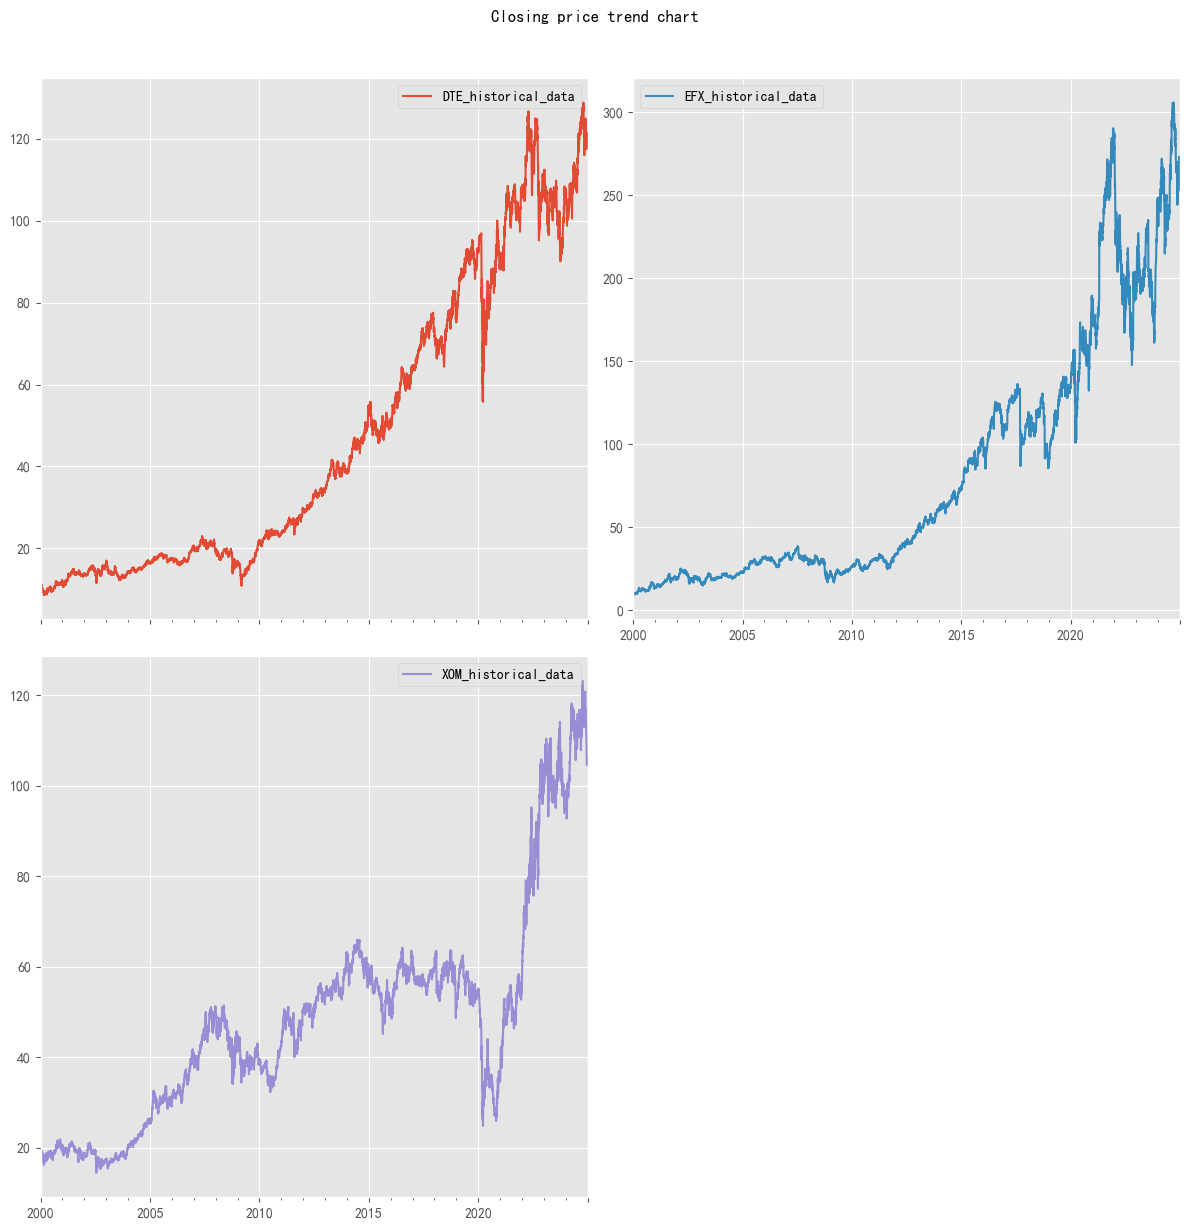

Summary of Closing Price Data:
        DTE_historical_data  EFX_historical_data  XOM_historical_data
count          6522.000000          6522.000000          6522.000000
mean             47.127853            81.848525            48.388661
std              35.146779            74.590662            23.806824
min               8.689282             9.362453            14.478676
25%              16.803733            24.518923            31.360896
50%              32.662079            40.347673            48.127888
75%              75.663067           122.388264            57.545143
max             128.821716           305.781799           123.245819


<Figure size 1200x600 with 0 Axes>

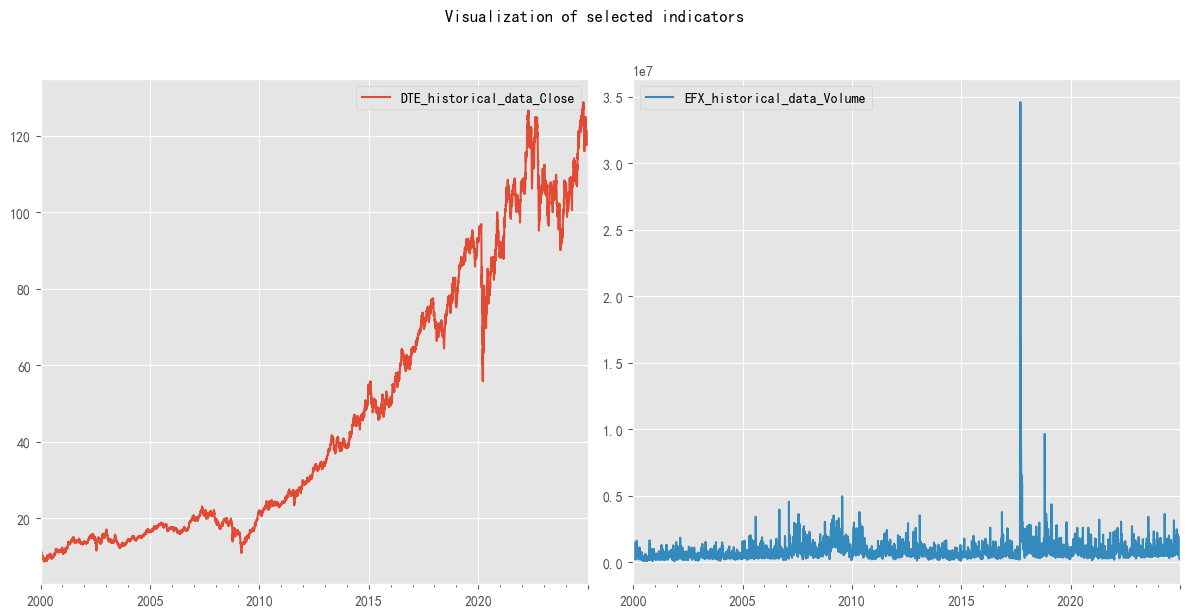

Complete Data Sample:
             DTE_historical_data_Open  DTE_historical_data_High  \
2000-01-03                  9.280894                  9.280894   
2000-01-04                  8.744748                  8.911139   
2000-01-05                  8.966607                  9.299388   

            DTE_historical_data_Low  DTE_historical_data_Close  
2000-01-03                 8.837186                   8.892650  
2000-01-04                 8.744748                   8.911139  
2000-01-05                 8.966607                   9.188461  


In [19]:
import pandas as pd 
import seaborn as sns 
from pathlib import Path 
from typing import Dict, List 
import matplotlib.pyplot as plt
 
class StockDataLoader:
    def __init__(self, data_dir: str = "Data"):
        self.data_dir  = Path(data_dir)
        self._validate_data_dir()

    # Validates if the specified data directory exists. If not, it raises an error.
    def _validate_data_dir(self):
        if not self.data_dir.exists(): 
            raise FileNotFoundError(f"The data directory does not exist: {self.data_dir}") 
        
    # Loads stock data from a single CSV file for a specific stock symbol. It reads the columns specified and ensures proper date parsing.
    def _load_single_stock(self, symbol: str, cols: List[str]) -> pd.DataFrame:
        file_path = self.data_dir  / f"{symbol}.csv"
        return pd.read_csv( 
            file_path,
            index_col='Date',
            parse_dates=True,
            usecols=cols,
            na_values=['nan', 'null']
        )
 
    # Retrieves the closing prices for a list of stock symbols over a given date range. The data is forward-filled to handle missing values.
    def get_close_prices(self, symbols: List[str], date_range: pd.DatetimeIndex) -> pd.DataFrame:

        result = pd.DataFrame(index=date_range)
        for sym in symbols:
            df = self._load_single_stock(sym, ['Date', 'Close'])
            result = result.join(df.rename(columns={'Close':  sym}))
        return result.ffill() 

    # Retrieves the full data (Open, High, Low, Close, Volume, OpenInt) for a list of stock symbols over a specified date range.
    def get_full_data(self, symbols: List[str], date_range: pd.DatetimeIndex) -> pd.DataFrame:
        result = pd.DataFrame(index=date_range)
        base_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        
        for sym in symbols:
            # Dynamic detection of available columns 
            sample = pd.read_csv(self.data_dir  / f"{sym}.csv", nrows=0)
            use_cols = [c for c in base_cols + ['OpenInt'] if c in sample.columns] 
            
            df = self._load_single_stock(sym, use_cols)
            df.columns  = [f"{sym}_{col}" for col in df.columns]  
            result = result.join(df) 
        
        # Smart fill logic 
        result = result.ffill().bfill() 
        
        # Handling missing OpenInt values 
        for sym in symbols:
            col = f"{sym}_OpenInt"
            if col not in result.columns: 
                result[col] = result[f"{sym}_Volume"].cumsum()
                
        return result 
 # Creates a line plot for the stock price data. If there’s only one stock, it uses seaborn for a single line plot. If there are multiple stocks, it creates subplots.
def visualize_data(data: pd.DataFrame, title: str):
    plt.figure(figsize=(12,  6))
    if len(data.columns)  == 1:
        sns.lineplot(data=data) 
    else:
        data.plot(subplots=True,  layout=(-1, 2), figsize=(12, 6*((len(data.columns)+1)//2))) 
    plt.suptitle(title,  y=1.02)
    plt.tight_layout() 
    plt.show() 
 
if __name__ == "__main__":
    # Configuration parameters 
    symbols = ['DTE_historical_data', 'EFX_historical_data', 'XOM_historical_data']
    date_range = pd.date_range('2000-01-01',  '2024-12-31', freq='B')
    
    # Instantiate loader 
    loader = StockDataLoader()
    
    # Retrieve and display closing price data 
    close_data = loader.get_close_prices(symbols,  date_range)
    visualize_data(close_data, "Closing price trend chart")
    print("Summary of Closing Price Data:\n", close_data.describe()) 
    
    # Retrieve and display complete data 
    full_data = loader.get_full_data(symbols,  date_range)
    visualize_data(full_data[['DTE_historical_data_Close', 'EFX_historical_data_Volume']], 
                  "Visualization of selected indicators")
    print("Complete Data Sample:\n", full_data.iloc[:3,  :4])

# Data analysis

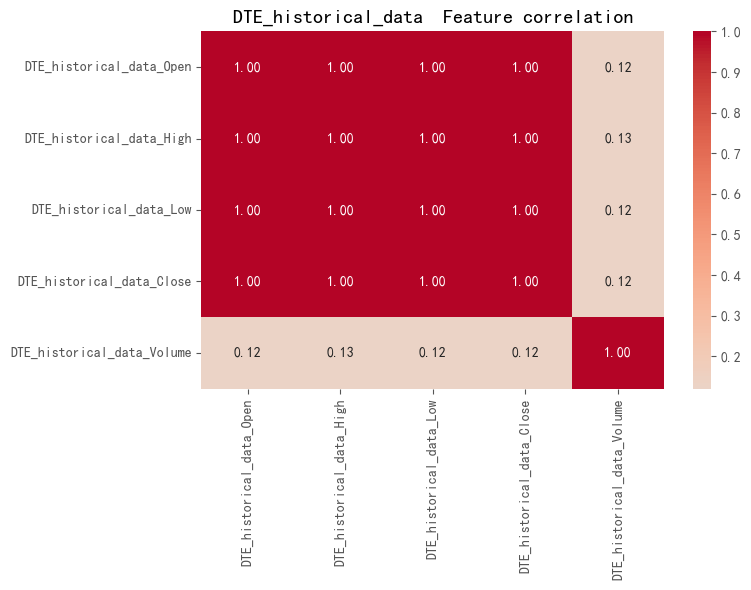

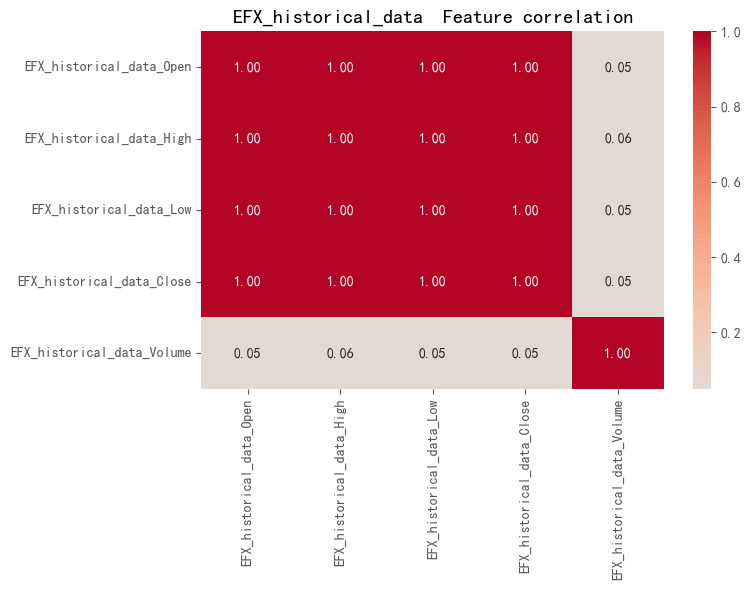

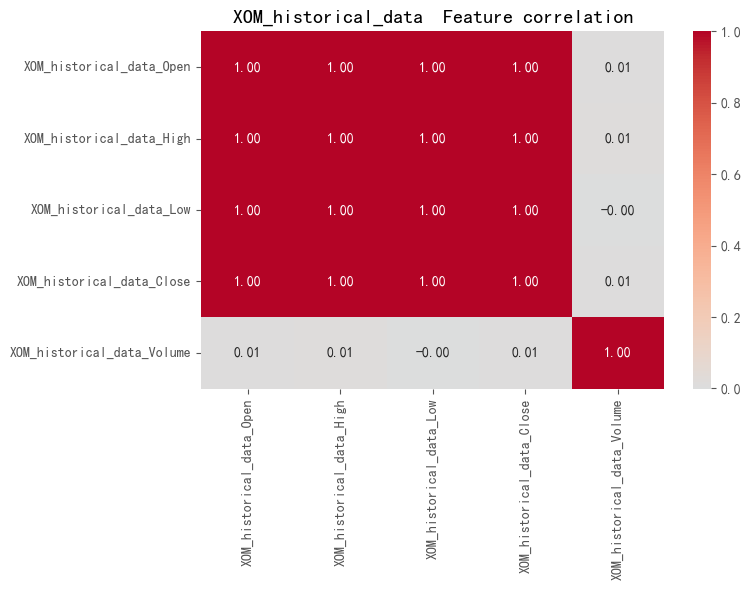

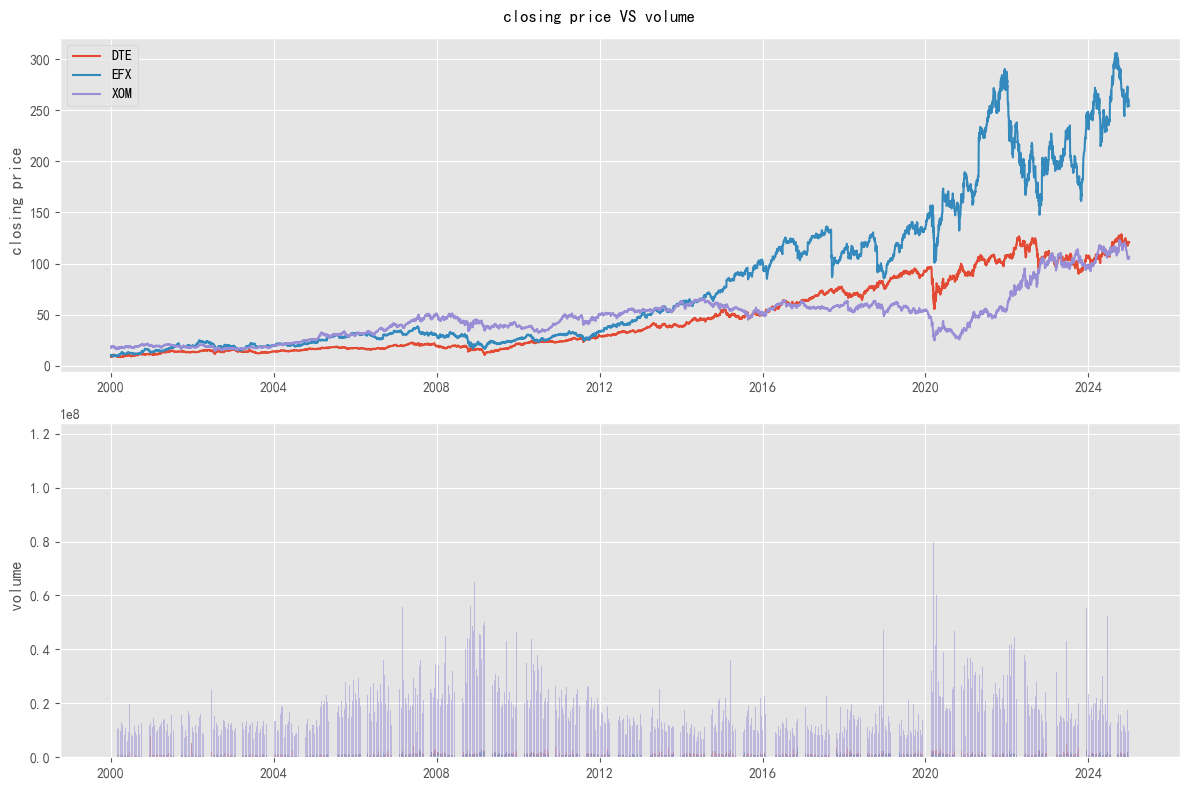

In [20]:
import seaborn as sns 
import matplotlib.pyplot  as plt 
from datetime import datetime 
 
# Global Settings 
plt.style.use('ggplot')  # Use ggplot style for plots
plt.rcParams['font.sans-serif'] = ['SimHei']  # Set font to SimHei for Chinese characters

def plot_stock_analysis(data, symbols):
   
    # 1. Correlation Analysis
 
    for stock in symbols:
        _plot_correlation(stock, data)
    
    # 2. Trend Analysis
 
    _plot_trend_comparison(data, symbols)
    
  # The _plot_correlation function plots the correlation heatmap for a given stock symbol's features, such as Open, High, Low, Close, and Volume.
def _plot_correlation(symbol, data):
    features = [f"{symbol}_{feat}" for feat in ['Open','High','Low','Close','Volume'] 
               if f"{symbol}_{feat}" in data.columns] 
    
    if len(features) < 2:
        print(f"⚠️ {symbol}: Insufficient features")
        return 
    
    plt.figure(figsize=(8,6)) 
    sns.heatmap(data[features].corr(),  
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt=".2f")
    plt.title(f'{symbol}  Feature correlation') 
    plt.tight_layout() 
    plt.show()
    plt.savefig(f'corr_{symbol}.png',  dpi=120)
    plt.close() 
 
 # This function compares the closing price and trading volume of the specified stock symbols over time, displaying the results in a two-panel plot.
def _plot_trend_comparison(data, symbols):
    fig, (ax1, ax2) = plt.subplots(2,  1, figsize=(12,8))
    
    # Price Trend 
    for sym in symbols:
        if f"{sym}_Close" in data.columns: 
            ax1.plot(data.index,  data[f"{sym}_Close"], label=sym.split('_')[0]) 
    ax1.set_ylabel(' closing price')
    ax1.legend() 
    
    # Volume Trend 
    for sym in symbols:
        if f"{sym}_Volume" in data.columns: 
            ax2.bar(data.index,  data[f"{sym}_Volume"], alpha=0.5, label=sym.split('_')[0]) 
    ax2.set_ylabel(' volume')
    
    fig.suptitle(' closing price VS volume')
    plt.tight_layout() 
    plt.savefig('trend_comparison.png',  dpi=120)
    plt.show()
    plt.close() 

    # Data Preparation
symbols = ['DTE_historical_data', 'EFX_historical_data', 'XOM_historical_data']
 
# Execution Analysis 
plot_stock_analysis(full_data, symbols)

mean_squared_error: Calculates the Mean Squared Error (MSE) between the true and predicted values.

mean_absolute_error: Computes the Mean Absolute Error (MAE) between the true and predicted values.

r2_score: Measures the coefficient of determination, which represents how well the regression predictions approximate the real data points.

math.sqrt: Used to calculate the square root for the Root Mean Squared Error (RMSE).

numpy: Although imported, it is not directly used in this code snippet, but it could be helpful for array handling or further optimizations.

In [21]:
from sklearn.metrics  import mean_squared_error, mean_absolute_error, r2_score 
import numpy as np 
import math 

def all_calculate_metrics( y_true, y_pred):
   
    metrics = {
        f"RMSE": math.sqrt(mean_squared_error(y_true,  y_pred)),
        f"MAE": mean_absolute_error(y_true, y_pred),
        f"R2": r2_score(y_true, y_pred)
    }
    return metrics 

# Conduct model establishment and data prediction

# Two ways to build LSTM models

Epoch [20/60], Loss: 0.0003
Early stopping at epoch 30
Train RMSE: 8.18, MAE: 5.69
Test RMSE: 14.77, MAE: 12.87


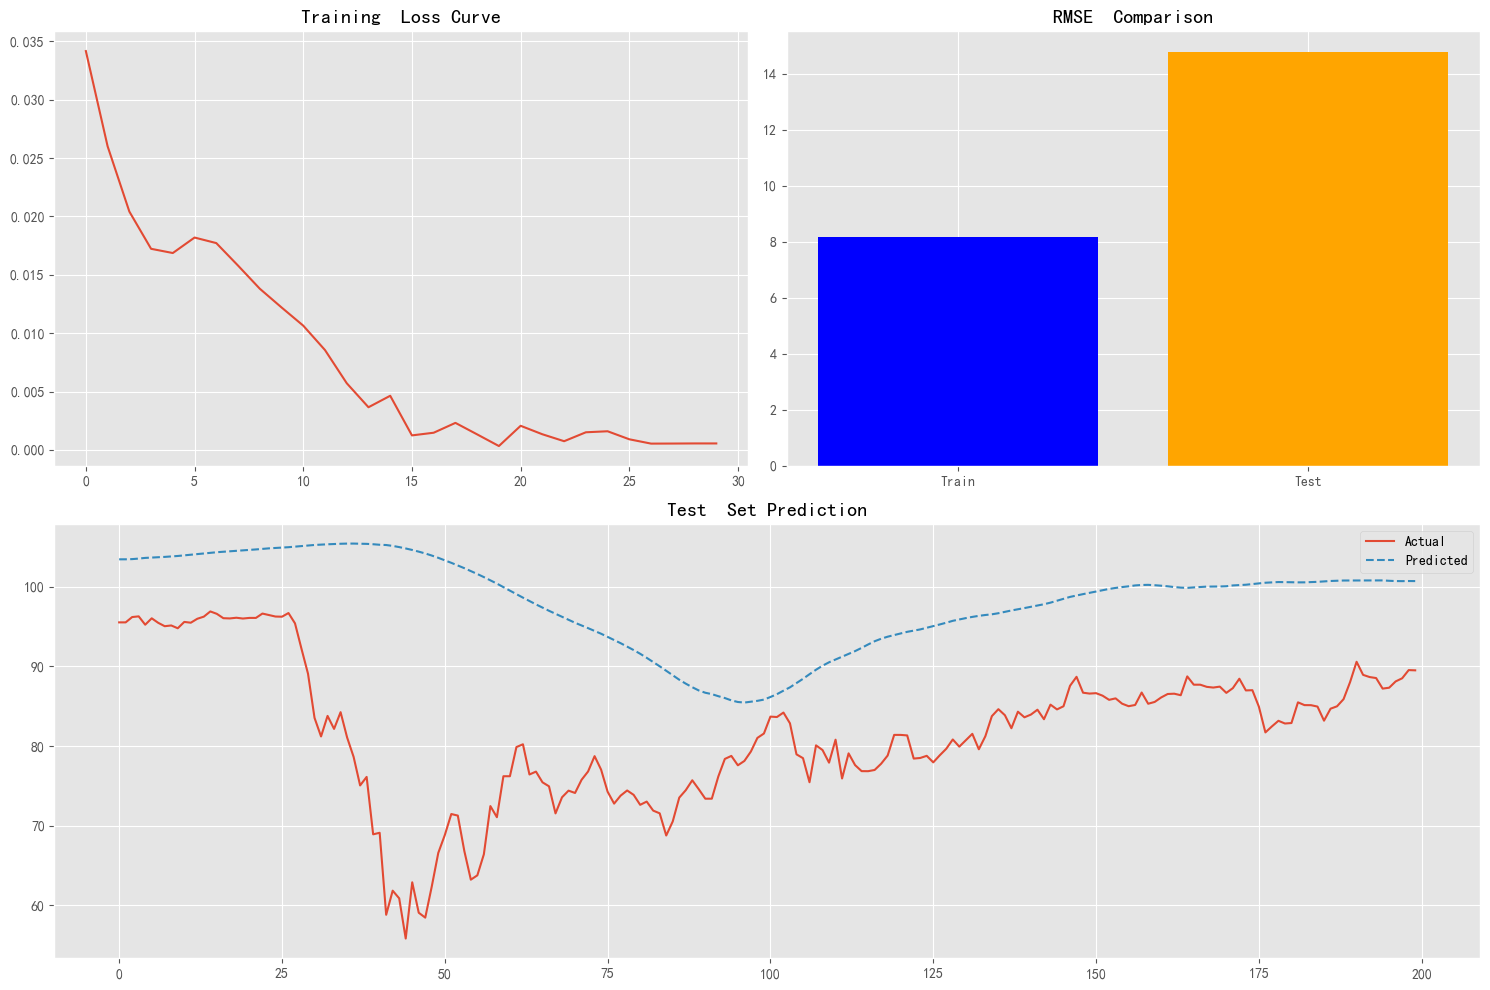

In [ ]:
import torch 
import torch.nn  as nn 
import numpy as np 
from sklearn.preprocessing  import MinMaxScaler 
from sklearn.metrics  import mean_squared_error 
import matplotlib.pyplot  as plt 
import math 
 
 # This is a custom LSTM model with an attention mechanism to enhance the model's focus on relevant parts of the sequence when making predictions.
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, output_size=1):
        super().__init__()
        self.lstm  = nn.LSTM(
            input_size, 
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0  # Enable dropout when multiple layers are used 
        )
        self.attention  = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.Tanh(),
            nn.Linear(32, 1, bias=False)
        )
        self.fc  = nn.Linear(hidden_size, output_size)
 
   #The lstm_out contains the hidden states from the LSTM layers, representing the temporal information.
    def forward(self, x):
        # LSTM layer output
 
        lstm_out, _ = self.lstm(x)   
        
        # Attention mechanism 
        attn_weights = torch.softmax(self.attention(lstm_out),  dim=1)
        context = torch.sum(attn_weights  * lstm_out, dim=1)
        
        return self.fc(context) 
 
# Prepares the dataset for time series forecasting by scaling the data and creating sequences of look_back steps to predict the next value.
def prepare_data(data, look_back=60, test_ratio=0.2):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data) 
    
    # Generate time series samples 
    X, y = [], []
    for i in range(len(scaled) - look_back):
        X.append(scaled[i:i+look_back,  :])
        y.append(scaled[i+look_back,  0])  
    
    X, y = np.array(X),  np.array(y) 
    
    # Divide the dataset 
    split = int((1 - test_ratio) * len(X))
    return X[:split], y[:split], X[split:], y[split:], scaler 
 
x_train, y_train, x_test, y_test, scaler = prepare_data(full_data)
 
# Convert to PyTorch Tensor and automatically detect devices
device = torch.device("cuda"  if torch.cuda.is_available()  else "cpu")
x_train_tensor = torch.FloatTensor(x_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
x_test_tensor = torch.FloatTensor(x_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)
 
# Initializes the EnhancedLSTM model with the appropriate input size.
model = EnhancedLSTM(input_size=x_train.shape[2]).to(device) 
criterion = nn.HuberLoss() 
optimizer = torch.optim.AdamW(model.parameters(),  lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  'min', patience=5)
 


# Training:

# For each epoch, the model is trained by performing forward propagation, computing the loss, and backpropagating the gradients.

# Gradient clipping: Ensures that the gradients do not explode by capping them to a maximum value.

# Early stopping: Stops training if the loss does not improve after a set number of epochs (patience).

# Checkpointing: Saves the model whenever the loss improves.

# Training loop
best_loss = float('inf')
patience, epochs = 0, 60
train_losses = []
 
for epoch in range(epochs):
    model.train() 
    optimizer.zero_grad() 
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(),  1.0)
    optimizer.step() 
    scheduler.step(loss) 
    
    train_losses.append(loss.item()) 
    
    # Early stopping detection 
    if loss.item()  < best_loss:
        best_loss = loss.item() 
        patience = 0 
        torch.save(model.state_dict(),  'best_model.pth') 
    else:
        patience += 1 
        if patience >= 10: 
            print(f"Early stopping at epoch {epoch+1}")
            break 
 
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}') 
 
# Load the best model 
model.load_state_dict(torch.load('best_model.pth')) 
 
# Prediction and denormalization 
model.eval() 
with torch.no_grad(): 
    train_preds = model(x_train_tensor).cpu().numpy()
    test_preds = model(x_test_tensor).cpu().numpy()
 
# Denormalization processing 
def inverse_transform(y, scaler, feature_idx=0):
    dummy = np.zeros((len(y),  scaler.n_features_in_))
    dummy[:, feature_idx] = y.flatten() 
    return scaler.inverse_transform(dummy)[:,  feature_idx]
 
y_train_actual = inverse_transform(y_train, scaler)
y_test_actual = inverse_transform(y_test, scaler)
train_preds_actual = inverse_transform(train_preds, scaler)
test_preds_actual = inverse_transform(test_preds, scaler)
 
# Evaluation metrics 
def calculate_metrics(actual, preds):
    rmse = math.sqrt(mean_squared_error(actual,  preds))
    mae = np.mean(np.abs(actual  - preds))
    return rmse, mae 
 
train_rmse, train_mae = calculate_metrics(y_train_actual, train_preds_actual)
test_rmse, test_mae = calculate_metrics(y_test_actual, test_preds_actual)
 
print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")
 
# Visualization results 
plt.figure(figsize=(15,  10))
plt.subplot(2,  2, 1)
plt.plot(train_losses) 
plt.title("Training  Loss Curve")
 
plt.subplot(2,  2, 2)
plt.bar(['Train',  'Test'], [train_rmse, test_rmse], color=['blue', 'orange'])
plt.title("RMSE  Comparison")
 
plt.subplot(2,  1, 2)
plt.plot(y_test_actual[:200],  label='Actual')
plt.plot(test_preds_actual[:200],  label='Predicted', linestyle='--')
plt.legend() 
plt.title("Test  Set Prediction")
plt.tight_layout() 
plt.show() 


In [23]:
print (all_calculate_metrics(y_test_actual, test_preds_actual))

{'RMSE': 14.773294385591582, 'MAE': 12.874528872616153, 'R2': -0.30701551433883645}


Training Progress: 100%|██████████| 200/200 [03:58<00:00,  1.19s/it, Train Loss=0.0001, Val Loss=0.0030]



=== Final assessment ===
DTE Train RMSE: 0.9070, MAE: 0.6186
DTE Test RMSE: 6.7447, MAE: 5.1707


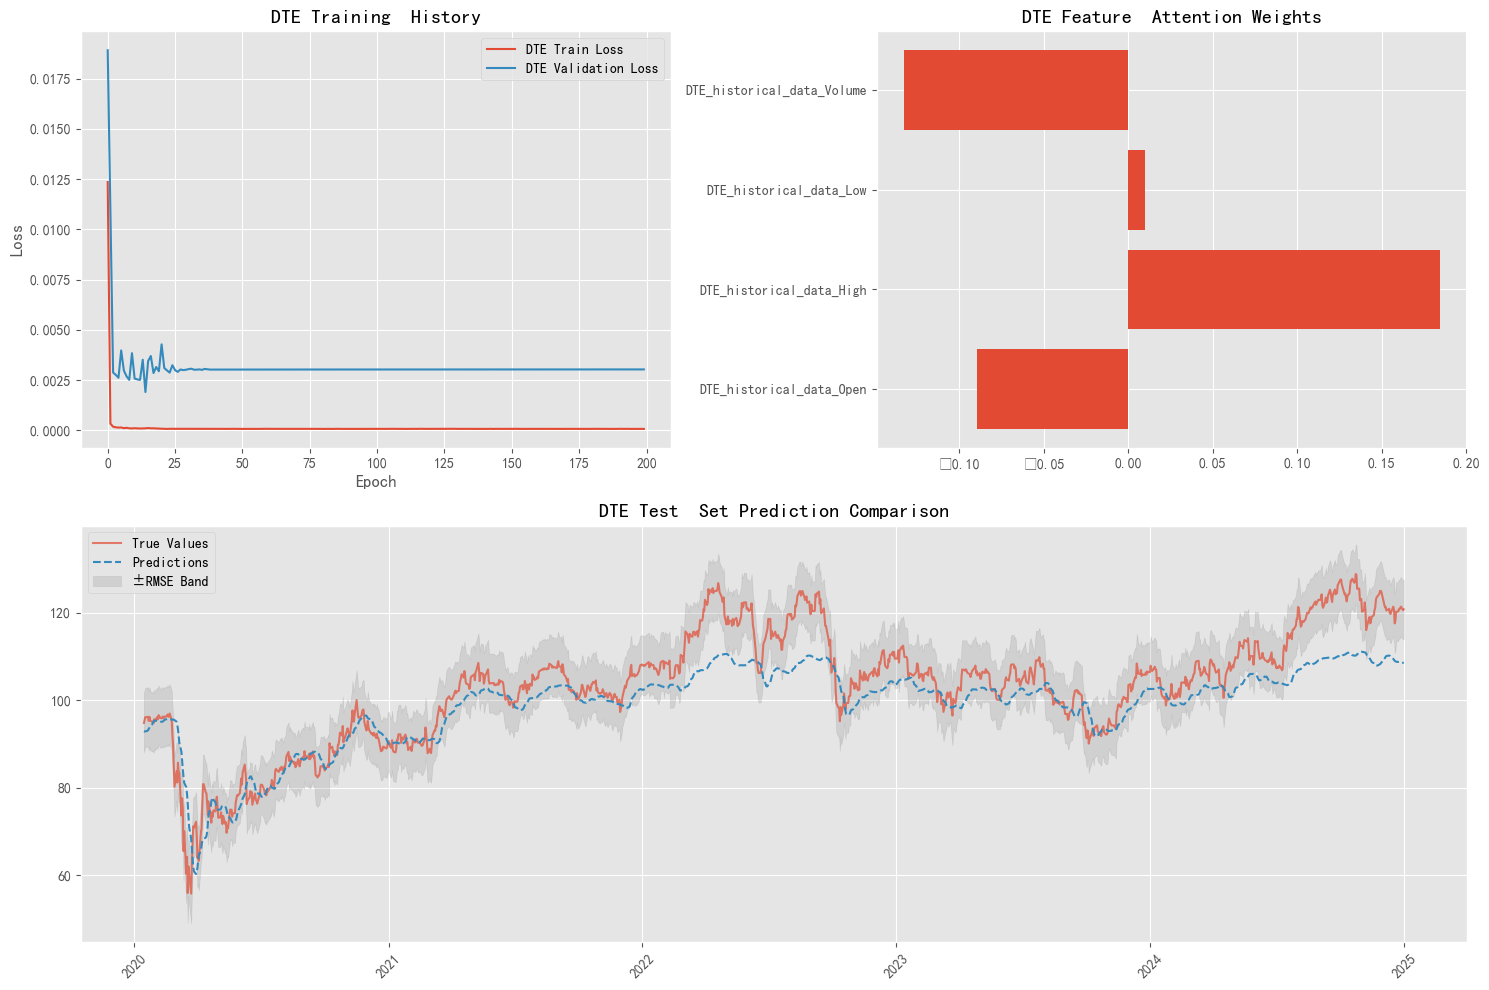

In [ ]:
import torch 
import torch.nn  as nn 
import torch.optim  as optim 
from sklearn.preprocessing  import MinMaxScaler 
from sklearn.metrics  import mean_squared_error, mean_absolute_error 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot  as plt 
from math import sqrt 
from torch.utils.data  import DataLoader, TensorDataset 
from tqdm import tqdm 
 

 # Initializes the DataProcessor class with the feature columns, label column, sequence length for time series data, and the test ratio.
class DataProcessor:
    def __init__(self, features, label, seq_length=10, test_ratio=0.2):
        self.features  = features 
        self.label  = label 
        self.seq_length  = seq_length 
        self.test_ratio  = test_ratio 
        self.scaler_x  = MinMaxScaler(feature_range=(0, 1))
        self.scaler_y  = MinMaxScaler(feature_range=(0, 1))
 #Splits the data into training and testing sets based on the specified test_ratio. It then normalizes the features and labels using MinMaxScaler.
    def process(self, full_data):
        # Data partitioning 
        split_idx = int(len(full_data) * (1 - self.test_ratio)) 
        train_data = full_data.iloc[:split_idx][self.features  + [self.label]]
        test_data = full_data.iloc[split_idx:][self.features  + [self.label]]
        
        # Normalization of features/labels 
        X_train = self.scaler_x.fit_transform(train_data[self.features]) 
        y_train = self.scaler_y.fit_transform(train_data[[self.label]]) 
        X_test = self.scaler_x.transform(test_data[self.features]) 
        y_test = self.scaler_y.transform(test_data[[self.label]]) 
        
        # Converts the dataset into sequences of length seq_length. This is necessary for training LSTM models that rely on temporal dependencies.
        def create_sequences(X, y):
            sequences = []
            targets = []
            for i in range(len(X) - self.seq_length): 
                sequences.append(X[i:i+self.seq_length]) 
                targets.append(y[i+self.seq_length]) 
            return np.array(sequences),  np.array(targets) 
        
        X_train_seq, y_train_seq = create_sequences(X_train, y_train)
        X_test_seq, y_test_seq = create_sequences(X_test, y_test)
        
        # Conversion to Tensor 
        X_train_tensor = torch.FloatTensor(X_train_seq)
        y_train_tensor = torch.FloatTensor(y_train_seq).squeeze()
        X_test_tensor = torch.FloatTensor(X_test_seq)
        y_test_tensor = torch.FloatTensor(y_test_seq).squeeze()
        
        return (X_train_tensor, y_train_tensor, 
                X_test_tensor, y_test_tensor, 
                test_data.index[self.seq_length:]) 
 
# Defines an LSTM-based model with an attention mechanism to improve sequence modeling by allowing the model to focus on important time steps.
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm  = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=0.3 if num_layers > 1 else 0 
        )
        self.attention  = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.Tanh(),
            nn.Linear(16, 1, bias=False)
        )
        self.fc  = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, output_size)
        )
 
    def forward(self, x):
        lstm_out, _ = self.lstm(x)   # [batch, seq_len, hidden_size]
        
        # Time attention mechanism 
        attn_weights = torch.softmax(self.attention(lstm_out),  dim=1)
        context = torch.sum(attn_weights  * lstm_out, dim=1)
        
        return self.fc(context) 
 
#  Initializes the trainer with the model and the device (GPU/CPU). The best_loss variable keeps track of the best loss achieved during training.
class LSTMTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available()  else 'cpu'):
        self.model  = model.to(device) 
        self.device  = device 
        self.best_loss  = float('inf')
        
    def train(self, X_train, y_train, X_test, y_test, 
              epochs=200, batch_size=64, lr=0.001):
        # Data loader 
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        criterion = nn.HuberLoss()  # Robustness loss function 
        optimizer = optim.AdamW(self.model.parameters(),  lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  'min', patience=5)
        
        train_losses, val_losses = [], []
        progress_bar = tqdm(range(epochs), desc='Training Progress')
        
        for epoch in progress_bar:
            # Training phase 
            self.model.train() 
            epoch_loss = 0 
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device),  y_batch.to(self.device) 
                optimizer.zero_grad() 
                outputs = self.model(X_batch) 
                loss = criterion(outputs, y_batch.unsqueeze(1)) 
                loss.backward() 
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),  1.0)
                optimizer.step() 
                epoch_loss += loss.item() 
            
            # Verification phase 
            val_loss = self.evaluate(X_test,  y_test, criterion)
            scheduler.step(val_loss) 
            
            # Loss recording 
            train_losses.append(epoch_loss/len(train_loader)) 
            val_losses.append(val_loss) 
            
            # Early stopping and model saving 
            if val_loss < self.best_loss: 
                self.best_loss  = val_loss 
                torch.save(self.model.state_dict(),  'best_lstm_model.pth') 
            
            progress_bar.set_postfix({ 
                'Train Loss': f"{train_losses[-1]:.4f}",
                'Val Loss': f"{val_losses[-1]:.4f}"
            })
        
        return train_losses, val_losses 
    
    def evaluate(self, X, y, criterion):
        self.model.eval() 
        with torch.no_grad(): 
            X, y = X.to(self.device),  y.to(self.device) 
            outputs = self.model(X) 
            return criterion(outputs, y.unsqueeze(1)).item() 
 
# ==================== Main execution flow ====================
if __name__ == "__main__":
    # Data preparation
    features = ['DTE_historical_data_Open', 'DTE_historical_data_High', 
                'DTE_historical_data_Low', 'DTE_historical_data_Volume']
    label = 'DTE_historical_data_Close'
    
    # Assume that full_data is a DataFrame containing features 
    processor = DataProcessor(features, label, seq_length=10)
    X_train, y_train, X_test, y_test, test_index = processor.process(full_data) 
    
    # Model training 
    model = EnhancedLSTM(input_size=len(features)) 
    trainer = LSTMTrainer(model)
    train_losses, val_losses = trainer.train(X_train,  y_train, X_test, y_test)
    
    # Prediction and denormalization 
    def inverse_predict(model, X, scaler_y):
        model.eval() 
        with torch.no_grad(): 
            preds = model(X.to(trainer.device)).cpu().numpy() 
        return scaler_y.inverse_transform(preds) 
    
    train_preds = inverse_predict(model, X_train, processor.scaler_y) 
    test_preds = inverse_predict(model, X_test, processor.scaler_y) 
    y_train_true = processor.scaler_y.inverse_transform(y_train.numpy().reshape(-1,  1))
    y_test_true = processor.scaler_y.inverse_transform(y_test.numpy().reshape(-1,  1))
    
    # Evaluation metrics 
    def calculate_metrics(true, pred):
        rmse = sqrt(mean_squared_error(true, pred))
        mae = mean_absolute_error(true, pred)
        return rmse, mae 
    
    train_rmse, train_mae = calculate_metrics(y_train_true, train_preds)
    test_rmse, test_mae = calculate_metrics(y_test_true, test_preds)
    
    print(f"\n=== Final assessment ===")
    print(f"DTE Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")
    print(f"DTE Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")
    
    # ==================== Advanced visualization ====================
    plt.figure(figsize=(15,  10))
    
    # Feature importance analysis 
    plt.subplot(2,  2, 1)
    plt.plot(train_losses,  label='DTE Train Loss')
    plt.plot(val_losses,  label='DTE Validation Loss')
    plt.title('DTE Training  History')
    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.legend() 
    
    plt.subplot(2,  2, 2)
    attention_weights = model.attention[2].weight.detach().cpu().numpy() 
    plt.barh(features,  attention_weights[0, :len(features)])
    plt.title('DTE Feature  Attention Weights')
    
    # Test set prediction comparison 
    plt.subplot(2,  1, 2)
    test_dates = test_index 
    plt.plot(test_dates,  y_test_true, label='True Values', alpha=0.7)
    plt.plot(test_dates,  test_preds, label='Predictions', linestyle='--')
    plt.fill_between(test_dates,  
                    (y_test_true.flatten()  - test_rmse), 
                    (y_test_true.flatten()  + test_rmse),
                    color='gray', alpha=0.2, label='±RMSE Band')
    plt.title('DTE Test  Set Prediction Comparison')
    plt.xticks(rotation=45) 
    plt.legend() 
    
    plt.tight_layout() 
    plt.show() 

In [25]:
print (all_calculate_metrics(y_test_true, test_preds))

{'RMSE': 6.744665227659793, 'MAE': 5.170661449432373, 'R2': 0.7261964082717896}


# Random Forest Model

Best Params: {'min_samples_split': 5, 'max_features': 0.8, 'max_depth': None}

=== Model performance ===
EFX Train RMSE: 0.1780, MAE: 0.1078, R²: 1.0000
EFX Test RMSE: 81.7926, MAE: 69.7742, R²: -2.4620


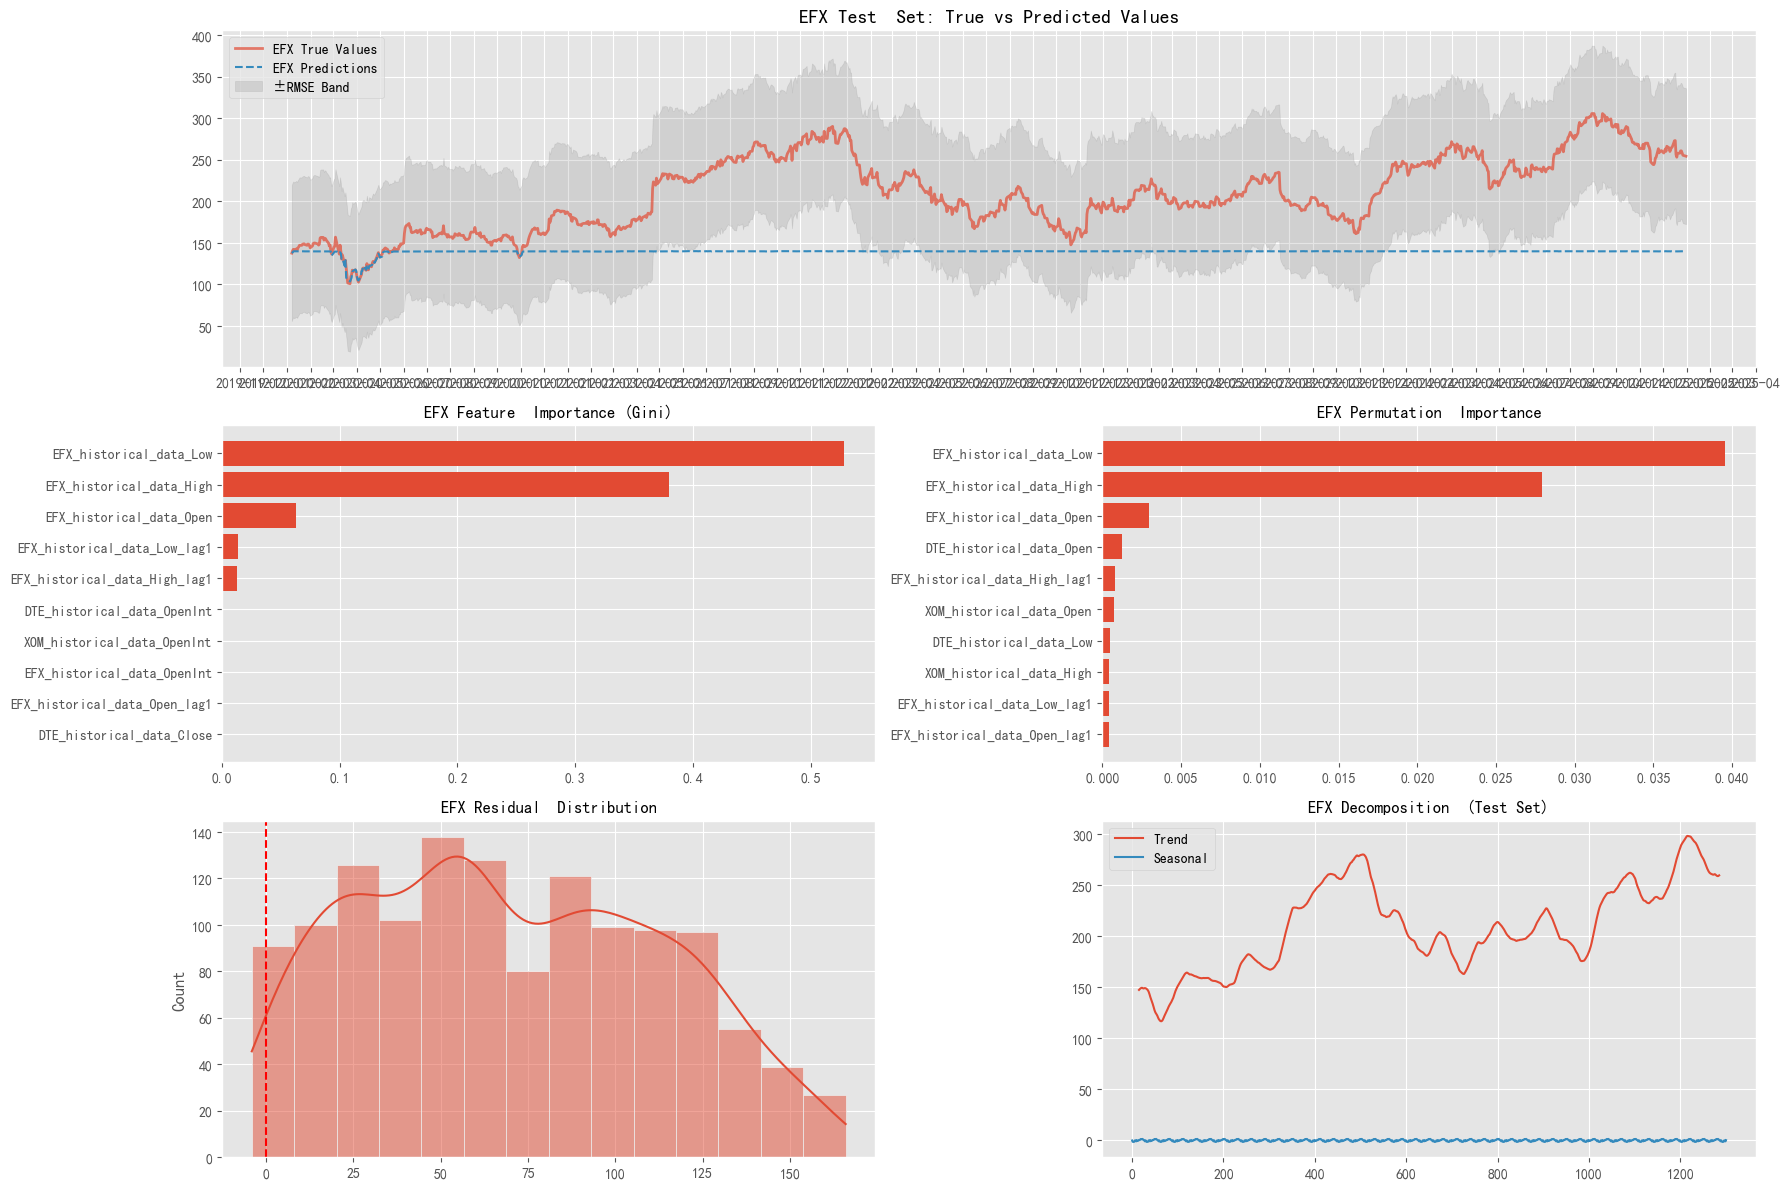

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot  as plt 
from sklearn.ensemble  import RandomForestRegressor 
from sklearn.preprocessing  import MinMaxScaler, StandardScaler 
from sklearn.metrics  import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection  import TimeSeriesSplit, RandomizedSearchCV 
from sklearn.inspection  import permutation_importance 
import matplotlib.dates  as mdates 
from statsmodels.tsa.seasonal  import seasonal_decompose 
import seaborn as sns 
 
# The TimeSeriesProcessor class is used for data preprocessing. It handles feature engineering (including lag features), scaling, and splitting the dataset into training and testing sets.
#Initializes the processor, defining the features, label, scaling method, and test ratio.
class TimeSeriesProcessor:
    def __init__(self, features, label, test_ratio=0.2, scale_method='minmax'):
        self.features  = features 
        self.label  = label 
        self.test_ratio  = test_ratio 
        self.scale_method  = scale_method 
        self.scaler_x  = MinMaxScaler() if scale_method == 'minmax' else StandardScaler()
        self.scaler_y  = MinMaxScaler() if scale_method == 'minmax' else StandardScaler()
        # Adds lag features (shifting the features by 1, 3, and 5 time steps) to capture temporal dependencies.
    def process(self, full_data):
        # Add lag features
        for lag in [1, 3, 5]:
            for feature in self.features: 
                full_data[f'{feature}_lag{lag}'] = full_data[feature].shift(lag)
        
        # Update feature columns
 
        extended_features = [col for col in full_data.columns  if col != self.label] 
        
        # Splits the data into training and test sets based on the test_ratio. It also creates a 5-period rolling mean as an additional feature.
        split_idx = int(len(full_data) * (1 - self.test_ratio)) 
        train_data = full_data.iloc[:split_idx].copy() 
        test_data = full_data.iloc[split_idx:].copy() 
        
        # Feature engineering 
        train_data['rolling_mean_5'] = train_data[self.label].rolling(5).mean()
        test_data['rolling_mean_5'] = test_data[self.label].rolling(5).mean()
        
        # Fill missing values
        train_data = train_data.dropna() 
        test_data = test_data.dropna() 
        
        #  Normalizes the features (X_train, X_test) and the label (y_train, y_test) using the appropriate scalers.
        X_train = self.scaler_x.fit_transform(train_data[extended_features]) 
        y_train = self.scaler_y.fit_transform(train_data[[self.label]]) 
        X_test = self.scaler_x.transform(test_data[extended_features]) 
        y_test = self.scaler_y.transform(test_data[[self.label]]) 
        
        return (X_train, y_train, 
                X_test, y_test, 
                train_data.index,  test_data.index, 
                extended_features)
 
# Initializes the Random Forest model with a specified number of trees (n_estimators) and a fixed random state for reproducibility.
class EnhancedRandomForest:
    def __init__(self, n_estimators=200, random_state=42):
        self.model  = RandomForestRegressor(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1,
            warm_start=True 
        )
        # Performs hyperparameter tuning using RandomizedSearchCV and cross-validation (TimeSeriesSplit), optimizing parameters like max_depth, min_samples_split, and max_features.
    def train(self, X_train, y_train, cv_splits=5):
        # Time series cross-validation 
        tscv = TimeSeriesSplit(n_splits=cv_splits)
        
        # Hyperparameter search space 
        param_dist = {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'max_features': ['sqrt', 'log2', 0.8]
        }
        
        # Random search optimization 
        search = RandomizedSearchCV(
            self.model,  param_dist, n_iter=10,
            cv=tscv, scoring='neg_mean_squared_error'
        )
        search.fit(X_train,  y_train.ravel()) 
        
        self.model  = search.best_estimator_ 
        print(f"Best Params: {search.best_params_}") 
        return search.cv_results_ 
 
    def evaluate(self, X, y, scaler_y):
        pred = self.model.predict(X) 
        pred = scaler_y.inverse_transform(pred.reshape(-1,  1))
        true = scaler_y.inverse_transform(y.reshape(-1,  1))
        
        rmse = np.sqrt(mean_squared_error(true,  pred))
        mae = mean_absolute_error(true, pred)
        r2 = r2_score(true, pred)
        
        return {
            'predictions': pred.flatten(), 
            'true_values': true.flatten(), 
            'rmse': rmse,
            'mae': mae,
            'r2': r2 
        }
 
# Data Preprocessing: Prepares the data by scaling, lagging features, and splitting it into training and testing sets.

# Model Training: Trains the Random Forest model with hyperparameter optimization.

# Model Evaluation: Evaluates the model on both the training and test sets.
if __name__ == "__main__":
    # Initialize configuration 
    features = ['EFX_historical_data_Open', 'EFX_historical_data_High', 
                'EFX_historical_data_Low', 'EFX_historical_data_Volume']
    label = 'EFX_historical_data_Close'
    
    # Data preprocessing 
    processor = TimeSeriesProcessor(features, label, scale_method='minmax')
    X_train, y_train, X_test, y_test, train_idx, test_idx, extended_features = processor.process(full_data) 
    
    # Model training 
    rf = EnhancedRandomForest(n_estimators=300)
    cv_results = rf.train(X_train,  y_train)
    
    # Model evaluation 
    train_results = rf.evaluate(X_train,  y_train, processor.scaler_y) 
    test_results = rf.evaluate(X_test,  y_test, processor.scaler_y) 
    
    print(f"\n=== Model performance ===")
    print(f"EFX Train RMSE: {train_results['rmse']:.4f}, MAE: {train_results['mae']:.4f}, R²: {train_results['r2']:.4f}")
    print(f"EFX Test RMSE: {test_results['rmse']:.4f}, MAE: {test_results['mae']:.4f}, R²: {test_results['r2']:.4f}")
 
    fig = plt.figure(figsize=(18,  12))
    gs = fig.add_gridspec(3,  2)
    
    # 1. Prediction comparison chart 
    ax1 = fig.add_subplot(gs[0,  :])
    ax1.plot(test_idx,  test_results['true_values'], label='EFX True Values', alpha=0.7, linewidth=2)
    ax1.plot(test_idx,  test_results['predictions'], label='EFX Predictions', linestyle='--')
    ax1.fill_between(test_idx,  
                    test_results['true_values'] - test_results['rmse'], 
                    test_results['true_values'] + test_results['rmse'],
                    color='gray', alpha=0.2, label='±RMSE Band')
    ax1.xaxis.set_major_locator(mdates.MonthLocator()) 
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
    ax1.set_title('EFX Test  Set: True vs Predicted Values', fontsize=14)
    ax1.legend() 
    
    # 2. Feature importance
    ax2 = fig.add_subplot(gs[1,  0])
    importances = rf.model.feature_importances_ 
    top_idx = np.argsort(importances)[-10:]  
    ax2.barh(np.array(extended_features)[top_idx],  importances[top_idx])
    ax2.set_title('EFX Feature  Importance (Gini)', fontsize=12)
    
    ax3 = fig.add_subplot(gs[1,  1])
    perm_importance = permutation_importance(rf.model,  X_test, y_test, n_repeats=10)
    top_idx = np.argsort(perm_importance.importances_mean)[-10:] 
    ax3.barh(np.array(extended_features)[top_idx],  perm_importance.importances_mean[top_idx]) 
    ax3.set_title('EFX Permutation  Importance', fontsize=12)
    
    # 3.Residual diagnosis chart
    ax4 = fig.add_subplot(gs[2,  0])
    residuals = test_results['true_values'] - test_results['predictions']
    sns.histplot(residuals,  kde=True, ax=ax4)
    ax4.axvline(x=0,  color='r', linestyle='--')
    ax4.set_title('EFX Residual  Distribution', fontsize=12)
    
    # 4. Time series decomposition
    ax5 = fig.add_subplot(gs[2,  1])
    decomp = seasonal_decompose(test_results['true_values'], period=30)
    ax5.plot(decomp.trend,  label='Trend')
    ax5.plot(decomp.seasonal,  label='Seasonal')
    ax5.set_title('EFX Decomposition  (Test Set)', fontsize=12)
    ax5.legend() 
    
    plt.tight_layout() 
    plt.show() 

# XGBoost model

🛠️ In feature engineering processing...
🔍 In hyperparameter optimization...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
🔥 optimum parameter: {'colsample_bytree': np.float64(0.6922091501757139), 'gamma': np.float64(0.015376645863987792), 'learning_rate': np.float64(0.24189195217707823), 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 493, 'subsample': np.float64(0.9651030323637335)}
📈 In model evaluation...

📊 TrainEvaluation results:
RMSE:  0.3990
MAE:  0.2867
MAPE:  0.0082
R2:  0.9993

📊 TestEvaluation results:
RMSE:  23.8846
MAE:  14.2923
MAPE:  0.1414
R2:  0.1700


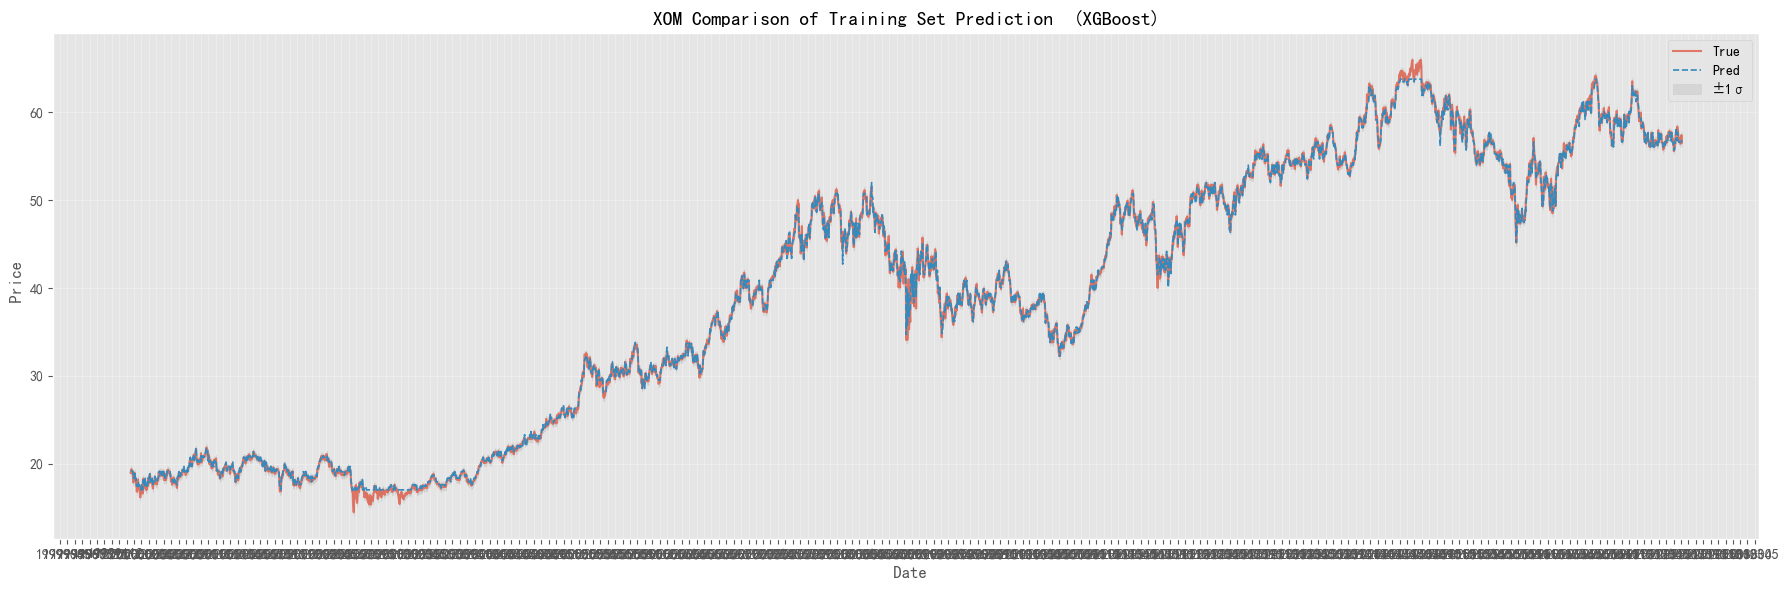

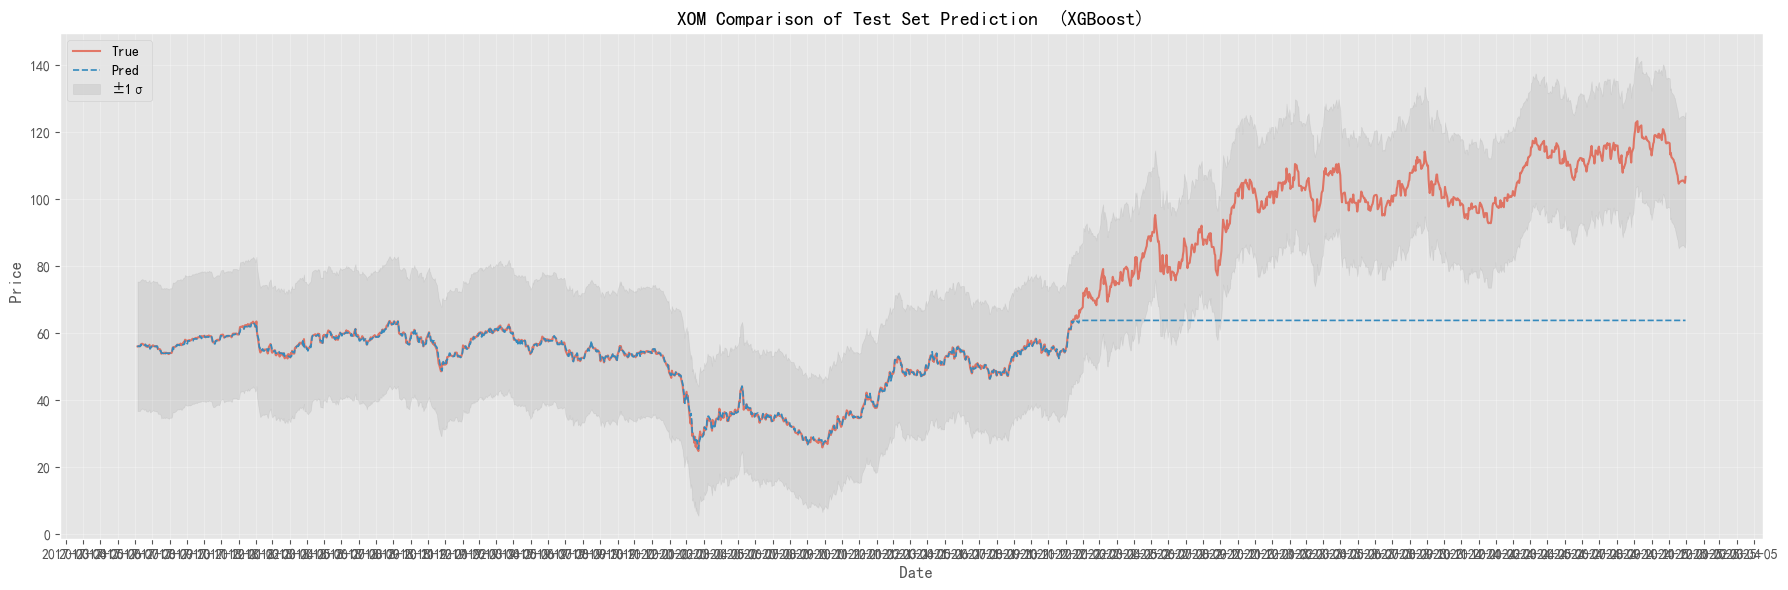

<Figure size 1200x600 with 0 Axes>

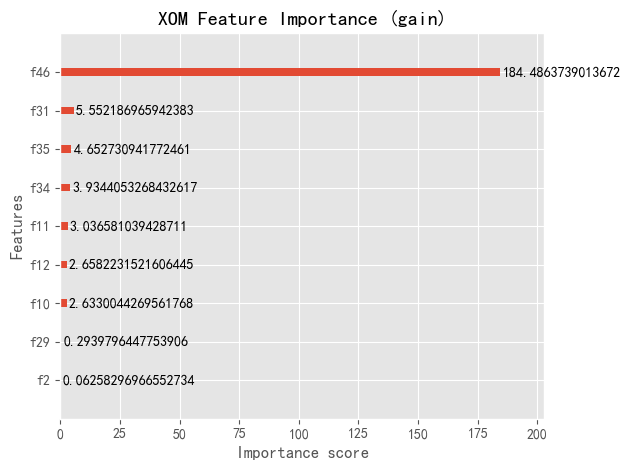

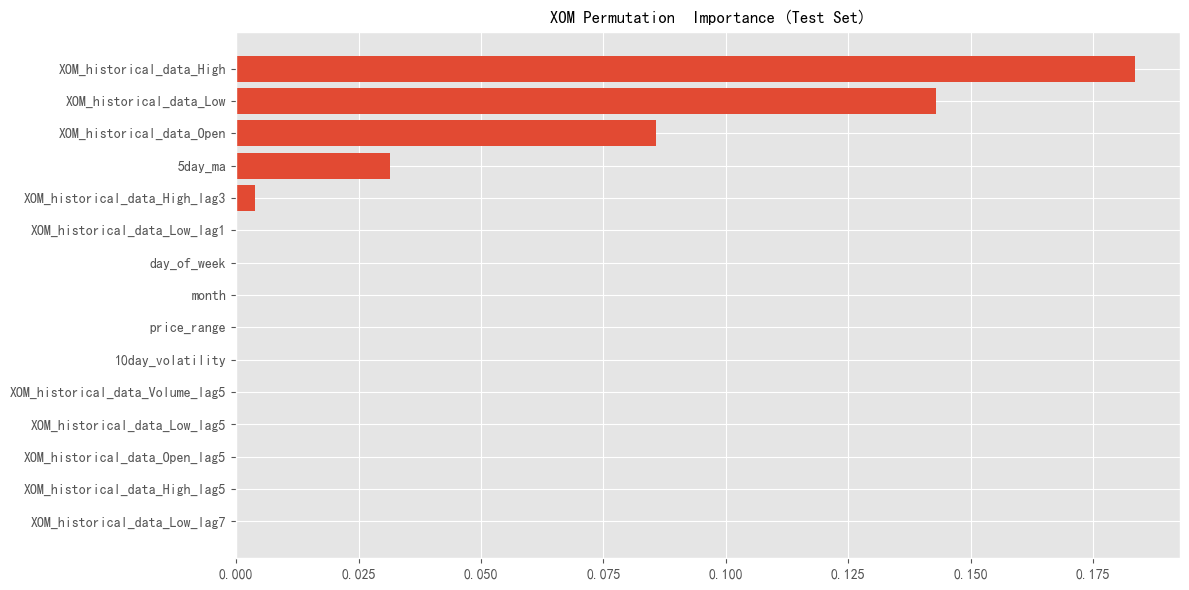

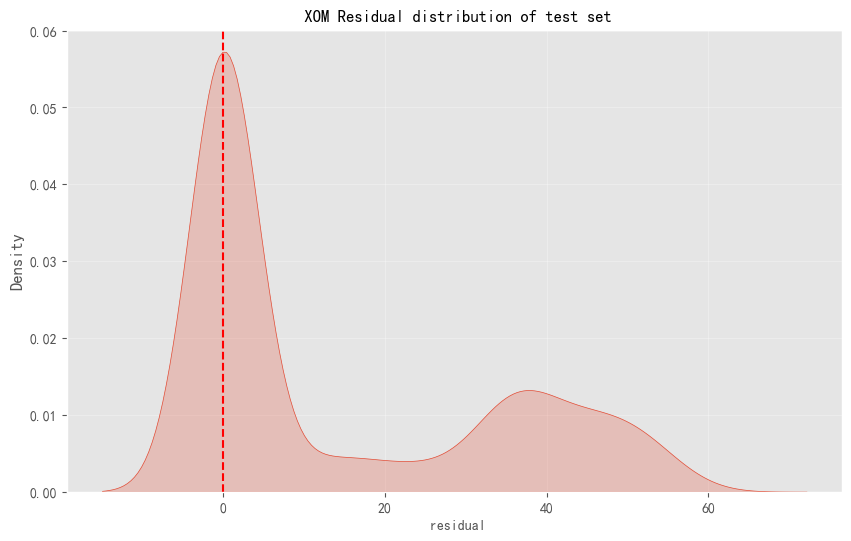

In [ ]:
import xgboost as xgb 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot  as plt 
import seaborn as sns 
from sklearn.preprocessing  import MinMaxScaler, RobustScaler 
from sklearn.model_selection  import TimeSeriesSplit, RandomizedSearchCV 
from sklearn.metrics  import (mean_squared_error, 
                            mean_absolute_error, 
                            r2_score,
                            mean_absolute_percentage_error)
from sklearn.inspection  import permutation_importance 
import matplotlib.dates  as mdates 
from scipy.stats  import randint, uniform 
import warnings 
warnings.filterwarnings('ignore') 
 
# Global Settings 

# Initializes the class with features, label, test ratio, and scaling methods. It uses RobustScaler for features (which is more robust to outliers) and MinMaxScaler for labels to scale them between 0.1 and 0.9.
class FeatureEngineer:
    def __init__(self, features, label, test_ratio=0.3):
        self.features  = features 
        self.label  = label 
        self.test_ratio  = test_ratio 
        self.scaler_x  = RobustScaler()  # More robust against outliers 
        self.scaler_y  = MinMaxScaler(feature_range=(0.1, 0.9))  
 

#  This function creates various types of features:

# Lag features: Shifts the features by 1, 3, 5, and 7 periods.

# Technical indicators: Includes price_range (difference between high and low), 5day_ma (5-day moving average), and 10day_volatility (10-day volatility).

# Time features: If the index is a DatetimeIndex, it adds day-of-week and month as features.
    def create_features(self, df):
        # Basic lag features 
        for lag in [1, 3, 5, 7]:
            for col in self.features: 
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
        
        # Technical indicator features 
        df['price_range'] = df['DTE_historical_data_High'] - df['DTE_historical_data_Low']
        df['5day_ma'] = df[self.label].rolling(5).mean()
        df['10day_volatility'] = df[self.label].pct_change().rolling(10).std()
        
        # Time features 
        if isinstance(df.index,  pd.DatetimeIndex):
            df['day_of_week'] = df.index.dayofweek  
            df['month'] = df.index.month  
        
        return df.dropna() 
 
#  Generating features using the create_features method.

# Splitting the dataset into training and testing sets.

# Scaling the features and labels using RobustScaler and MinMaxScaler.
    def prepare_data(self, full_data):
        # Feature generation 
        df = self.create_features(full_data.copy()) 
        
        # Time series segmentation 
        split_idx = int(len(df) * (1 - self.test_ratio)) 
        train_data = df.iloc[:split_idx] 
        test_data = df.iloc[split_idx:] 
        
        # Feature expansion 
        all_features = [col for col in df.columns  if col != self.label] 
        
        # Normalization 
        X_train = self.scaler_x.fit_transform(train_data[all_features]) 
        y_train = self.scaler_y.fit_transform(train_data[[self.label]]) 
        X_test = self.scaler_x.transform(test_data[all_features]) 
        y_test = self.scaler_y.transform(test_data[[self.label]]) 
        
        return (X_train, y_train.ravel(), 
                X_test, y_test.ravel(), 
                train_data.index,  test_data.index, 
                all_features)
 
# Initializes the class with base parameters for the XGBoost model. The objective is set to reg:squarederror, and the evaluation metric includes RMSE and MAE.
class XGBoostOptimizer:
    def __init__(self, random_state=42):
        self.base_params  = {
            'objective': 'reg:squarederror',
            'n_jobs': -1,
            'random_state': random_state,
            'eval_metric': ['rmse', 'mae']
        }
    # Uses RandomizedSearchCV to tune the hyperparameters of the XGBoost model. The search space includes parameters like max_depth, learning_rate, n_estimators, subsample, and others.
    def hyperparam_tuning(self, X_train, y_train, cv_splits=5):
        param_dist = {
            'max_depth': randint(3, 8),
            'learning_rate': uniform(0.01, 0.3),
            'n_estimators': randint(100, 500),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'gamma': uniform(0, 0.5),
            'min_child_weight': randint(1, 10)
        }
        
        tscv = TimeSeriesSplit(n_splits=cv_splits)
        model = xgb.XGBRegressor(**self.base_params) 
        
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=30,  # Iteration count 
            scoring='neg_mean_absolute_error',
            cv=tscv,
            verbose=1 
        )
        search.fit(X_train,  y_train)
        
        self.best_model  = search.best_estimator_ 
        print(f"🔥 optimum parameter: {search.best_params_}") 
        return search.best_estimator_ 
  # Evaluates the model's performance on the provided data (X, y) and returns a dictionary of evaluation metrics (RMSE, MAE, MAPE, and R²).
    def evaluate(self, model, X, y, scaler_y, prefix=""):
        pred = model.predict(X) 
        pred = scaler_y.inverse_transform(pred.reshape(-1,  1))
        true = scaler_y.inverse_transform(y.reshape(-1,  1))
        
        metrics = {
            'rmse': np.sqrt(mean_squared_error(true,  pred)),
            'mae': mean_absolute_error(true, pred),
            'mape': mean_absolute_percentage_error(true, pred),
            'r2': r2_score(true, pred)
        }
        
        print(f"\n📊 {prefix}Evaluation results:")
        for k, v in metrics.items(): 
            print(f"{k.upper()}:  {v:.4f}")
            
        return {'pred': pred.flatten(),  'true': true.flatten(),  'metrics': metrics}
 
# Plots the true vs. predicted values, with an error band representing ±1 standard deviation of residuals.
class Visualizer:
    @staticmethod 
    def plot_predictions(true, pred, index, title):
        plt.figure(figsize=(18,  6))
        plt.plot(index,  true, label='True', alpha=0.7, linewidth=1.5)
        plt.plot(index,  pred, label='Pred', linestyle='--', linewidth=1.2)
        plt.fill_between(index,  
                        true.flatten()  - np.std(true-pred),  
                        true.flatten()  + np.std(true-pred), 
                        color='gray', alpha=0.15, label='±1σ')
        plt.title(f'{title}  (XGBoost)', fontsize=14)
        plt.xlabel(' Date', fontsize=12)
        plt.ylabel(' Price', fontsize=12)
        plt.legend() 
        plt.grid(True,  alpha=0.3)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
        plt.tight_layout() 
        # Plots feature importance using either Gini importance (weight) or permutation importance.
    @staticmethod 
    def plot_feature_importance(model, features, method='weight'):
        plt.figure(figsize=(12,  6))
        if method == 'permutation':
            result = permutation_importance(model, X_test, y_test, n_repeats=10)
            sorted_idx = result.importances_mean.argsort() 
            plt.barh(np.array(features)[sorted_idx][-15:],  
                    result.importances_mean[sorted_idx][-15:]) 
            plt.title("XOM Permutation  Importance (Test Set)", fontsize=12)
        else:
            xgb.plot_importance(model,  importance_type=method, 
                              max_num_features=15, 
                              title=f'XOM Feature Importance ({method})')
        plt.tight_layout() 
 
# Feature Engineering: Prepares the data with lag features, technical indicators, and time-related features.

# Model Training: Trains the XGBoost model using hyperparameter optimization.

# Evaluation: Evaluates the model on both training and test sets.

# Visualization: Plots prediction comparisons, feature importance, and residual distribution
if __name__ == "__main__":
    # Initialization configuration 
    features = ['XOM_historical_data_Open', 'XOM_historical_data_High', 
                'XOM_historical_data_Low', 'XOM_historical_data_Volume']
    label = 'XOM_historical_data_Close'
    
    # Feature engineering 
    print("🛠️ In feature engineering processing...")
    engineer = FeatureEngineer(features, label, test_ratio=0.3)
    X_train, y_train, X_test, y_test, train_idx, test_idx, all_features = engineer.prepare_data(full_data) 
    
    # Model optimization 
    print("🔍 In hyperparameter optimization...")
    optimizer = XGBoostOptimizer()
    best_model = optimizer.hyperparam_tuning(X_train,  y_train)
    
    # Model evaluation 
    print("📈 In model evaluation...")
    train_results = optimizer.evaluate(best_model,  X_train, y_train, engineer.scaler_y,  "Train")
    test_results = optimizer.evaluate(best_model,  X_test, y_test, engineer.scaler_y,  "Test")
    
    # Visualization 
    Visualizer.plot_predictions(train_results['true'],  train_results['pred'], 
                              train_idx, "XOM Comparison of Training Set Prediction")
    Visualizer.plot_predictions(test_results['true'],  test_results['pred'], 
                              test_idx, "XOM Comparison of Test Set Prediction")
    Visualizer.plot_feature_importance(best_model,  all_features, method='gain')
    Visualizer.plot_feature_importance(best_model,  all_features, method='permutation')
    
    # Error analysis 
    residuals = test_results['true'] - test_results['pred']
    plt.figure(figsize=(10,  6))
    sns.kdeplot(residuals,  shade=True)
    plt.axvline(x=0,  color='r', linestyle='--')
    plt.title(' XOM Residual distribution of test set', fontsize=12)
    plt.xlabel(' residual', fontsize=10)
    plt.grid(True,  alpha=0.3)
    plt.show() 

## 5. linear simulation

Test RMSE: 0.0087
Test MAPE: 0.84%


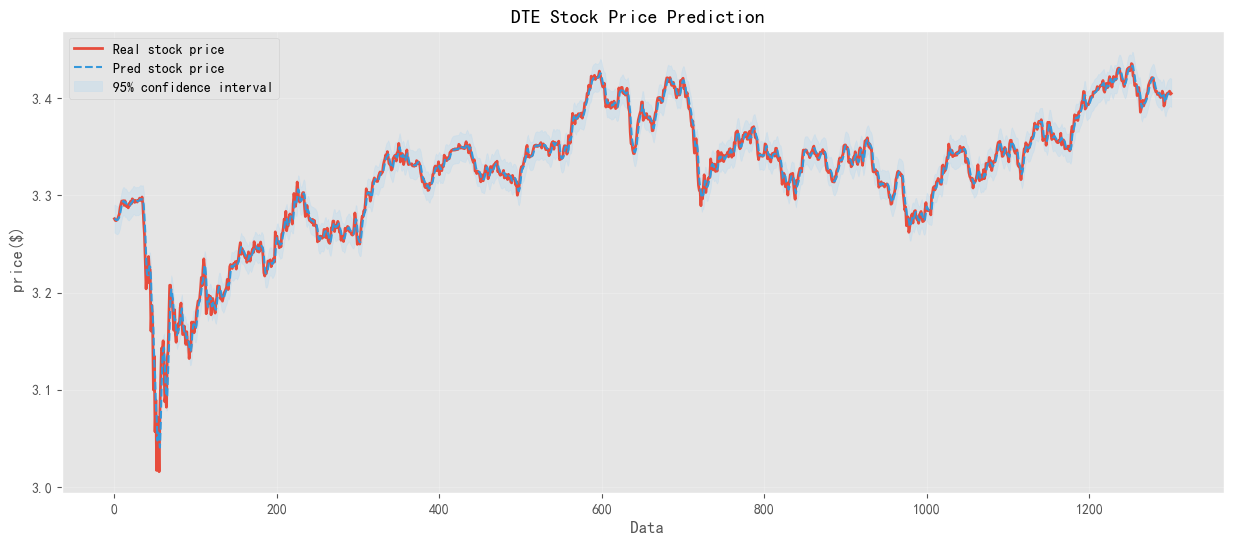

{'RMSE': 0.00874071219013271, 'MAE': 0.0054700575298273855, 'R2': 0.987275884083819}


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot  as plt 
from sklearn.linear_model  import Ridge 
from sklearn.preprocessing  import RobustScaler 
from sklearn.model_selection  import TimeSeriesSplit 
from sklearn.metrics  import mean_squared_error, mean_absolute_percentage_error 
from statsmodels.tsa.stattools  import adfuller 
from scipy.stats  import boxcox 
 
# The check_stationarity function uses the Augmented Dickey-Fuller test to check if a time series is stationary. A p-value below 0.05 indicates the series is stationary.
def check_stationarity(series):
    result = adfuller(series.dropna()) 
    return result[1] < 0.05  # p-value threshold 
 
 # Purpose: This function prepares the data by:

# Stationarity Check: If the time series is not stationary, it applies the Box-Cox transformation to stabilize the variance.

# Scaling: Uses the RobustScaler to scale the data and handle potential outliers.

# Time Series Split: Splits the data into training and testing sets based on the test_size parameter.
def prepare_data(series, test_size=0.2):
  
    # Smoothness transformation 
    if not check_stationarity(series):
        transformed, _ = boxcox(series + 1)  # Box-Cox transformation
        series = pd.Series(transformed, index=series.index) 
    
    # Normalization 
    scaler = RobustScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1,  1))
    
    # Time series segmentation 
    split_idx = int(len(scaled) * (1 - test_size))
    return scaled[:split_idx], scaled[split_idx:], scaler 
 
# The create_rolling_features function generates lag features (lags of the time series), rolling mean, and rolling standard deviation over a specified look-back period. These features help capture temporal dependencies in the time series.
def create_rolling_features(data, look_back=3):
   
    df = pd.DataFrame(data, columns=['value'])
    for i in range(1, look_back+1):
        df[f'lag_{i}'] = df['value'].shift(i)
    
    df['rolling_mean'] = df['value'].rolling(look_back).mean()
    df['rolling_std'] = df['value'].rolling(look_back).std()
    return df.dropna().values  
 
# This function trains a Ridge regression model using the training data and evaluates it on the test data. The model's predictions are evaluated using RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error).
def train_evaluate(X_train, y_train, X_test, y_test):
  
    model = Ridge(alpha=0.5)
    model.fit(X_train,  y_train)
    
    # Prediction results 
    preds = {
        'train': model.predict(X_train), 
        'test': model.predict(X_test) 
    }
    
    # Evaluation metrics 
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test,  preds['test'])),
        'MAPE': mean_absolute_percentage_error(y_test, preds['test'])
    }
    return preds, metrics 
 
# The plot_results function visualizes the true vs. predicted values of the stock prices, with a shaded area representing the 95% confidence interval around the predictions.
def plot_results(y_true, y_pred, scaler, title):
    # Inverse normalization 
    true = scaler.inverse_transform(y_true.reshape(-1,  1))
    pred = scaler.inverse_transform(y_pred.reshape(-1,  1))
    
    # Calculate confidence intervals 
    residuals = true - pred 
    std = np.std(residuals) 
    
    plt.figure(figsize=(15,  6))
    plt.plot(true,  color='#E74C3C', label='Real stock price', linewidth=2)
    plt.plot(pred,  color='#3498DB', linestyle='--', label='Pred stock price')
    
    # Confidence intervals 
    plt.fill_between( 
        range(len(true)), 
        (pred - 1.96*std).flatten(), 
        (pred + 1.96*std).flatten(),
        color='#AED6F1', alpha=0.3, label='95% confidence interval'
    )
    
    # Dynamic labeling 
    plt.title(f'{title} ', fontsize=14)
    plt.xlabel(' Data', fontsize=12)
    plt.ylabel(' price($)', fontsize=12)
    plt.legend() 
    plt.grid(alpha=0.2) 
    plt.show() 
 
# ==================== Main workflow ====================
if __name__ == "__main__":
    # Data preparation 
    train, test, scaler = prepare_data(full_data['DTE_historical_data_Close'])
    
    # Feature generation
    X_train = create_rolling_features(train, look_back=3)
    X_test = create_rolling_features(test, look_back=3)
    y_train = X_train[:, 0]  
    y_test = X_test[:, 0]
    X_train = X_train[:, 1:]  
    X_test = X_test[:, 1:]
    
    # Training and evaluation 
    preds, metrics = train_evaluate(X_train, y_train, X_test, y_test)
    print(f"Test RMSE: {metrics['RMSE']:.4f}")
    print(f"Test MAPE: {metrics['MAPE']:.2%}") 
    
    # Result visualization 
    plot_results(y_test, preds['test'], scaler, 'DTE Stock Price Prediction')

    print (all_calculate_metrics(y_test, preds['test']))